# CV Assignment 1

## Roll no - 20171002

### Requirements :-
##### Libraries:-
* Numpy
* os
* Python 3.x
* scikit-image
* matplotlib
* math
* mpl_toolkits.axes_grid1

### To run this notebook successfully, please ensure the following steps.
* Ensure that all the libraries mentioned above are installed
* Ensure that in the current working directory the folder **Camera_calibration_data** and its entire folder structure exists and is maintained. **This is the input data to notebook.**



### Note:-
* ***If any of the steps are missing/files are missing, then some parts of the code may or may not work***
* *The Results folder contains some outputs saved from the script*
* It is advised to use the testing machine in "plugged in" mode, to avoid core suppression as happens in most modern PCs.
* **Results are uploaded on Google drive at this link, `https://drive.google.com/open?id=1QOgm_wno9pYvRvBzRknx6pwMwwWjrify`**.Please note that this is hosted on IIITH's Google Drive.
* Resources are also uploaded in case in they are not uploadable on Moodle under the name `A1_resources`, at this link **`https://drive.google.com/open?id=10pYr-TawIxTIQBav-0iifm0HhzEg4WMk`**. If need be, copy the directory to the location of this iPython notebook. Please note that this is hosted on IIITH's Google Drive.

In [2]:
# Importing libraries
import numpy as np
import os, random
import skimage
from imageio import imread, imwrite
import matplotlib
import matplotlib.pyplot as plt
from math import sqrt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import cv2,math
import time
%matplotlib inline

In [3]:
# RGB to greyscale
def rgb2gray(image):
    '''
    A function that takes in input an image and returns its greyscale version
    '''
    if (len(image.shape)==2):
        return image
    elif (len(image.shape)==3):
        r = image[:,:,0]
        g = image[:,:,1]
        b = image[:,:,2]
        output = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return output.astype('uint8')

## Task 1

## Direct Linear Transform

For the given image calib-object.jpg using any 20-30 different points on different planes
and perform the Direct Linear Transform (DLT) based calibration as discussed in class.
Report the projection matrix, camera matrix, rotation matrix and projection center.
Note that you need to manually estimate the image co-ordinates of the given world
points and refer to calib-object-legend.jpg for world measurements. Each chessblock is
28X28 mm.


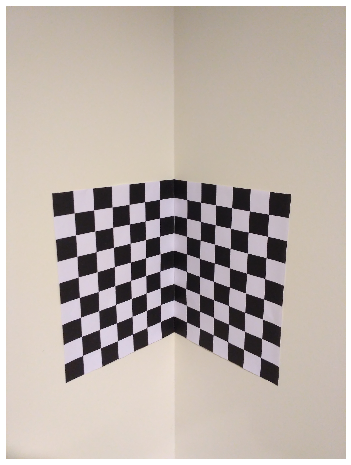

In [4]:
checkerboard = imread('./Camera_calibration_data/calib-object.jpg')
plt.figure(figsize = [10,10], dpi = 60)
plt.imshow(checkerboard)
plt.axis('off')
plt.show()

In [5]:
n=20
world = np.zeros((n,3))
world[:,0] = np.array([[28, 28*2, 28*3, 28*4, 28*5, 28*6, 28*7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
world[:,1] = np.array([[0, 0, 0, 0, 0, 0, 0, 28, 28*2, 28*3, 28*4, 28*5, 28*6, 28*7, 28*8, 0, 0, 0, 0, 0]])
world[:,2] = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 28*2, 28*3, 28*4, 28*5]])
world = world.astype('int64')
image = np.zeros((n,2))
image[:,0] = np.array([[1664, 1795, 1932, 2083, 2247, 2421, 2619, 1546, 1545, 1544, 1543, 1543, 1545, 1545, 1545, 1410, 1281, 1134, 975, 801]])
image[:,1] = np.array([[1615, 1629, 1648, 1666, 1687, 1710, 1733, 1764, 1931, 2089, 2252, 2403, 2557, 2706, 2853, 1608, 1624, 1642, 1660, 1678]])
image = image.astype('int64')
print('world = \n',world)
print('image = \n',image)

world = 
 [[ 28   0   0]
 [ 56   0   0]
 [ 84   0   0]
 [112   0   0]
 [140   0   0]
 [168   0   0]
 [196   0   0]
 [  0  28   0]
 [  0  56   0]
 [  0  84   0]
 [  0 112   0]
 [  0 140   0]
 [  0 168   0]
 [  0 196   0]
 [  0 224   0]
 [  0   0  28]
 [  0   0  56]
 [  0   0  84]
 [  0   0 112]
 [  0   0 140]]
image = 
 [[1664 1615]
 [1795 1629]
 [1932 1648]
 [2083 1666]
 [2247 1687]
 [2421 1710]
 [2619 1733]
 [1546 1764]
 [1545 1931]
 [1544 2089]
 [1543 2252]
 [1543 2403]
 [1545 2557]
 [1545 2706]
 [1545 2853]
 [1410 1608]
 [1281 1624]
 [1134 1642]
 [ 975 1660]
 [ 801 1678]]


In [6]:
# TO BE FILLED
def calibration(world, image, normalise = False):
    """
    world is a variable containing n_world number of points and column vectors containing 3 numbers (x,y,z)
    image is a variable containing n_image number of points and column vectors containing 2 numbers (x,y)
    """
    n_world = world.shape[0]
    n_image = image.shape[0]
    if (n_image != n_world):
        raise ValueError('Number of 2D image points and 3D image points are unequal.')
    if (n_world < 6):
        raise ValueError('Atleast 6 points needed.')
        
    if normalise is True:
        # normalisation to place mean at center and ensure mean distance is 1 in each direction
        mu, std = np.mean(world,0), np.std(world)
        #world_dash = normalised world pts
        world_dash = np.array([[std, 0, 0, mu[0]],[0, std, 0, mu[1]],[0, 0, std, mu[2]],[0, 0, 0, 1]])
        world_dash = np.linalg.inv(world_dash)
        world_copy = world.copy()
        #world_T = translation plus scaling for normalisation
        world_T = np.dot(world_dash, np.concatenate((world_copy.T, np.ones((1,world_copy.shape[0])))))
        world_T = world_T[0:3,:].T
    
        # normalisation to place mean at center and ensure mean distance is 1 in each direction
        mu, std = np.mean(image,0), np.std(image)
        #image_dash = normalised image pts
        image_dash = np.array([[std, 0, mu[0]],[0, std, mu[1]],[0, 0, 1]])
        image_dash = np.linalg.inv(image_dash)
        image_copy = image.copy()
        #image_T = translation plus scaling for normalisation
        image_T = np.dot(image_dash, np.concatenate((image_copy.T, np.ones((1,image_copy.shape[0])))))
        image_T = image_T[0:3,:].T
    
    A = []
    for i in range(n_world):
        if normalise is True:
            x, y, z = world_T[i,0], world_T[i,1], world_T[i,2]
            u, v = image_T[i,0], image_T[i,1]
        else:
            x, y, z = world[i,0], world[i,1], world[i,2]
            u, v = image[i,0], image[i,1]
        
        A.append([x, y, z, 1, 0, 0, 0, 0, -u*x, -u*y, -u*z, -u])
        A.append([0, 0, 0, 0, x, y, z, 1, -v*x, -v*y, -v*z, -v])
    A = np.asarray(A)
    u,s,v = np.linalg.svd(A)
    P = v[-1,:]/v[-1,-1]
    P = P.reshape(3,4)
    if normalise is True:
        p = np.dot(np.dot(np.linalg.pinv(image_dash), P), world_dash)
        p = p / p[-1,-1]
    else:
        p = P
        
    H_inf = p[:,0:3]
    h = -1*p[:,3]
    R, K = np.linalg.qr(H_inf)
    C = np.dot(np.linalg.pinv(H_inf),h)
    bp = np.dot(p, np.concatenate((world.T, np.ones((1,world.shape[0])))))
    bp=bp/bp[2,:]
    e = np.sqrt(np.mean(np.sum((bp[0:2,:].T-image)**2,1)))
#     L = p.flatten(0)
    return p, R, K, C, e


In [6]:
P, R, K, C, e = calibration(world, image, normalise=True)
print('P = \n',P)
print('K = \n',K)
print('R = \n',R)
print('Translation = \n',C)
print('Error = ',e)

P = 
 [[ 2.25908844e+00  5.68773012e-01 -6.27306489e+00  1.54322991e+03]
 [-1.43169604e+00  6.64322894e+00 -1.47151210e+00  1.59682992e+03]
 [-1.23029881e-03  3.63287961e-04 -1.22146917e-03  1.00000000e+00]]
K = 
 [[-2.67455335e+00  3.07571970e+00  4.51090229e+00]
 [ 0.00000000e+00 -5.91573681e+00  4.60091687e+00]
 [ 0.00000000e+00  0.00000000e+00 -4.11432495e-03]]
R = 
 [[-8.44660077e-01 -5.35302830e-01  4.83697454e-04]
 [ 5.35302851e-01 -8.44660197e-01 -9.60981445e-05]
 [ 4.60001595e-04  1.77754360e-04  9.99999878e-01]]
Translation = 
 [408.76465448 -66.51225645 387.18474719]
Error =  2.3343098753434006


Implement the RANSAC based variant of the above calibration method and report
your observations.

In [7]:
def run_ransac(world, image, n = 20, iters = 50, num_pts = 10, normalise = True, init_err = 9):
    e_min = init_err
    for itr in range(iters):
        print('iter #',itr+1)
        idx = []
        world_pts = []
        img_pts = []
        while len(idx)<num_pts:
            r = random.randint(0,n-1)
            if r not in idx:
                idx.append(r)
                world_pts.append(world[r,:])
                img_pts.append(image[r,:])
        world_pts = np.array(world_pts)
        img_pts = np.array(img_pts)
        P, K, R, C, E = calibration(world_pts, img_pts, normalise=normalise)
        if (E < e_min):
            P_best, K_best, R_best, C_best, E_best = P, K, R, C, E
            e_min = E
        print('error = ',e_min)
        print('--------------------------------------------------')    
    return P_best, K_best, R_best, C_best, E_best

In [93]:
P_best, K_best, R_best, C_best, E_best = run_ransac(world, image)
print('P = \n',P_best)
print('K = \n',K_best)
print('R = \n',R_best)
print('Translation = \n',C_best)
print('Error = ',E_best)

iter # 1
error =  2.1945331320358408
--------------------------------------------------
iter # 2
error =  1.0089772196128683
--------------------------------------------------
iter # 3
error =  1.0089772196128683
--------------------------------------------------
iter # 4
error =  1.0089772196128683
--------------------------------------------------
iter # 5
error =  1.0089772196128683
--------------------------------------------------
iter # 6
error =  1.0089772196128683
--------------------------------------------------
iter # 7
error =  1.0089772196128683
--------------------------------------------------
iter # 8
error =  1.0089772196128683
--------------------------------------------------
iter # 9
error =  0.9555230220472366
--------------------------------------------------
iter # 10
error =  0.9555230220472366
--------------------------------------------------
iter # 11
error =  0.9555230220472366
--------------------------------------------------
iter # 12
error =  0.955523022

Repeat the above experiments after correcting for radial distortion. Estimate the
radial distortion parameters from the straight lines in the image. What do you observe
regarding the resulting parameters?

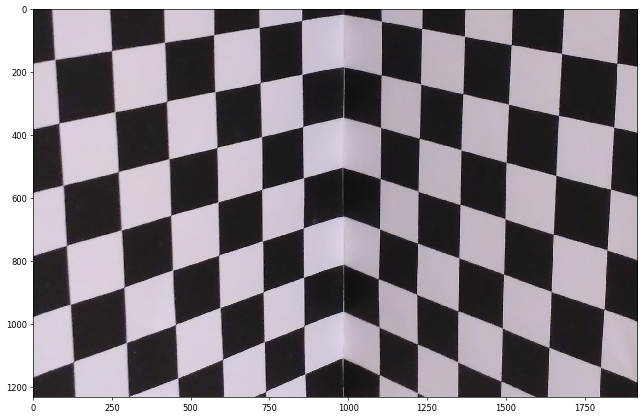

In [8]:
im = imread('./Camera_calibration_data/Fig1.png')
plt.figure(figsize = [13,13], dpi = 60)
plt.imshow(im)
plt.show()

Reprojection Error:
 1.5436143447441633
Camera Calibration Matrix:

[[1.07620107e+04 0.00000000e+00 1.04101600e+03]
 [0.00000000e+00 4.12295682e+03 7.66389379e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Parameters:

[[ 2.90290067e+00 -2.93263382e+02 -1.10051813e-04 -9.34062469e-04
   6.66335661e+03]]
Rotation Vectors for the images are:

[array([[0.25165926],
       [1.29200934],
       [0.18933474]])]
Translation Vectors for the images are:

[array([[  -3.14491973],
       [-123.93303489],
       [ 696.77945064]])]


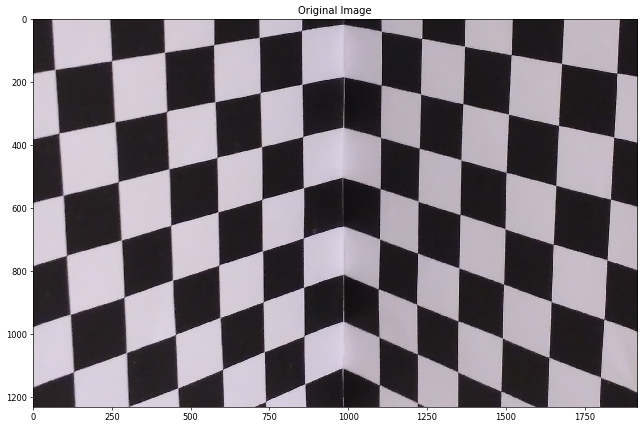

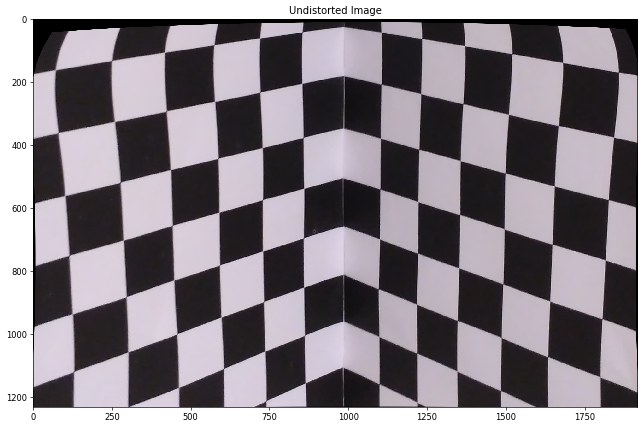

In [9]:
im = imread('./Camera_calibration_data/Fig1.png')
world = np.array([[28,0,0],[28*2,0,0],[28*3,0,0],[28*4,0,0],[28*5,0,0],[28,28,0],[28,28*2,0],[28,28*3,0],[28,28*4,0],[28,28*5,0],[28,28*6,0],[28,28*7,0]])
image = np.array([[1110,52],[1236,71],[1373,102],[1522,124],[1683,153],[1110,226],[1110,388],[1110,553],[1110,715],[1110,869],[1110,1025],[1110,1174]])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera([world.astype('float32')], [image.astype('float32')], (im.shape[1],im.shape[0]), None, None)
im2 = cv2.undistort(im, mtx, dist)
cv2.imwrite('./results/Undistorted.jpg',im2)
print('Reprojection Error:\n', ret)
print ('Camera Calibration Matrix:\n')
print(mtx)
print('Distortion Parameters:\n')
print(dist)
print('Rotation Vectors for the images are:\n')
print(rvecs)
print('Translation Vectors for the images are:\n')
print(tvecs)
plt.figure(figsize = [13,13], dpi = 60)
plt.imshow(im)
plt.title('Original Image')
plt.show()
plt.figure(figsize = [13,13], dpi = 60)
plt.imshow(im2)
plt.title('Undistorted Image')
plt.show()

In [12]:
world= np.array([[0.,0.,0.], [28.,0.,0.], [28.,28.,0.], [28.,56.,0.], [56.,56.,0.], [84.,84.,0.], [0.,28.,0.], [0.,56.,0.],[0.,84.,0.],[0.,0.,28.],
           [0.,0.,56.],[0.,28.,28.],[0.,56.,28.],[0.,84.,56.],[0.,84.,112.],[0.,140.,0.]])

image=np.array([[991.,50.],[1104.,70.],[1102.,228.],[1100.,389.],[1219.,420.],[1347.,623.],[988.,205.],[986.,356.],[983.,508.],
                  [866.,70.],[739.,87.],[863.,228],[863.,383],[731.,574],[456.,655.],[985.,813.]])
P_best, K_best, R_best, C_best, E_best = run_ransac(world, image, n=16, num_pts=6, iters=20)
print('P = \n',P_best)
print('K = \n',K_best)
print('R = \n',R_best)
print('Translation = \n',C_best)
print('Error = ',E_best)

iter # 1
error =  9
--------------------------------------------------
iter # 2
error =  6.119301797772257
--------------------------------------------------
iter # 3
error =  0.6772300201333151
--------------------------------------------------
iter # 4
error =  0.3729693922089757
--------------------------------------------------
iter # 5
error =  0.3729693922089757
--------------------------------------------------
iter # 6
error =  0.3729693922089757
--------------------------------------------------
iter # 7
error =  0.3729693922089757
--------------------------------------------------
iter # 8
error =  0.3729693922089757
--------------------------------------------------
iter # 9
error =  0.3729693922089757
--------------------------------------------------
iter # 10
error =  0.3729693922089757
--------------------------------------------------
iter # 11
error =  0.3729693922089757
--------------------------------------------------
iter # 12
error =  0.3729693922089757
----------

## Task 2

## Zhang's Method

Use checkerboard images IMG5456.JPG - IMG5470.JPG and perform camera calibration using Zhang’s Method. You can use the available OpenCV or Matlab implementation.

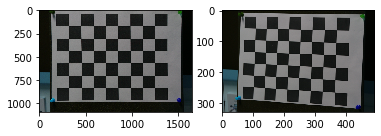

In [17]:
I1 = imread('./Camera_calibration_data/IMG_5456.JPG')
I2 = imread('./Camera_calibration_data/IMG_5457.JPG')
scale_percent = 30 # percent of original size
width = int(I1.shape[1] * scale_percent / 100)
height = int(I1.shape[0] * scale_percent / 100)
dim = (width, height)
I1 = cv2.resize(I1, dim, interpolation = cv2.INTER_AREA)
width = int(I1.shape[1] * scale_percent / 100)
height = int(I1.shape[0] * scale_percent / 100)
dim = (width, height)
I2 = cv2.resize(I2, dim, interpolation = cv2.INTER_AREA)
plt.subplot(121)
plt.imshow(I1[...,::-1])
plt.subplot(122)
plt.imshow(I2[...,::-1])
plt.show()
ret, corners = cv2.findChessboardCorners(I2
                                         ,(8,6)
#                                          ,flags=cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_NORMALIZE_IMAGE
                                        )
corners = corners.reshape(-1,2)
x,y=np.meshgrid(range(8),range(6))
world_points=np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)))).astype(np.float32)

In [18]:
# Function to convert the Rotation Matrix into the Euler Angles
def eulerAnglesToRotationMatrix(theta) :
    R_x = np.array([[1,0,0],[0,math.cos(theta[0]),-math.sin(theta[0])],[0,math.sin(theta[0]), math.cos(theta[0])]])
    R_y = np.array([[math.cos(theta[1]),0,math.sin(theta[1])],[0,1,0],[-math.sin(theta[1]),0,math.cos(theta[1])]])             
    R_z = np.array([[math.cos(theta[2]),-math.sin(theta[2]),0],[math.sin(theta[2]),math.cos(theta[2]),0],[0,0,1]])
    R = np.dot(R_z,np.dot(R_y,R_x))
    return R

In [19]:
_3d_points=[]
_2d_points=[]

for i in range(5456,5471):
    im=cv2.imread('./Camera_calibration_data/IMG_' + str(i) + '.JPG')
    scale_percent = 30 # percent of original size
    width = int(im.shape[1] * scale_percent / 100)
    height = int(im.shape[0] * scale_percent / 100)
    dim = (width, height)
    im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    ret, corners = cv2.findChessboardCorners(im, (8,6))
    
    if ret: #add points only if checkerboard was correctly detected:
        _2d_points.append(corners) #append current 2D points
        _3d_points.append(world_points) #3D points are always the same
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(_3d_points, _2d_points, (im.shape[1],im.shape[0]), None, None)

print('Reprojection Error:', ret)
print ('Camera Calibration Matrix:')
print(mtx)
print('Distortion Parameters:')
print(dist)
print('Rotation Vectors for the images are:')
print(rvecs)
print('Translation Vectors for the images are:')
print(tvecs)


Reprojection Error: 0.6918830757623777
Camera Calibration Matrix:
[[4.09090506e+03 0.00000000e+00 9.92907304e+02]
 [0.00000000e+00 4.09765128e+03 4.49180561e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Parameters:
[[ 9.87614890e-02  9.14679621e+00 -1.55110048e-02  2.68325306e-02
  -1.42142271e+02]]
Rotation Vectors for the images are:
[array([[-0.01110976],
       [-0.04676852],
       [-0.00308252]]), array([[-0.00664118],
       [ 0.22856355],
       [ 0.03517733]]), array([[-0.00959844],
       [-0.41416004],
       [-0.03562783]]), array([[ 0.01607633],
       [-0.61668574],
       [-0.07777176]]), array([[0.00509558],
       [0.31030283],
       [0.06529203]]), array([[-0.32569839],
       [-0.22013957],
       [-0.0169231 ]]), array([[-0.19325554],
       [-0.38306221],
       [-0.00384341]]), array([[ 0.2447513 ],
       [-0.32063027],
       [ 0.02439726]]), array([[0.31017231],
       [0.0688029 ],
       [0.07006609]]), array([[ 0.34941576],
       [-0.561

*Using the estimated camera parameters compute the image points and overlay a wireframe over the actual image of chessboard using straight lines between the computed
points. Refer to example-wireframe.png for reference. What do you observe about the
overlay? Note that do not use the image points found using the cv2.FindChessboardCorners for wireframe overlay. Size of each square on checkerboard
28mmX28mm*

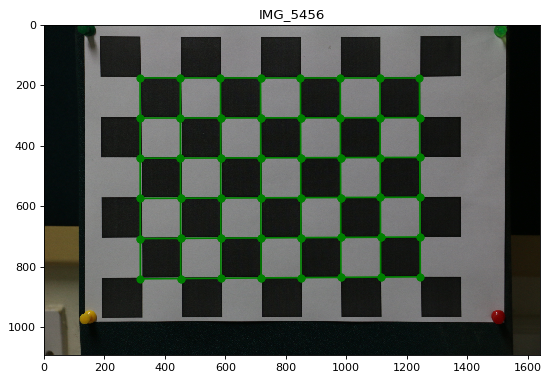

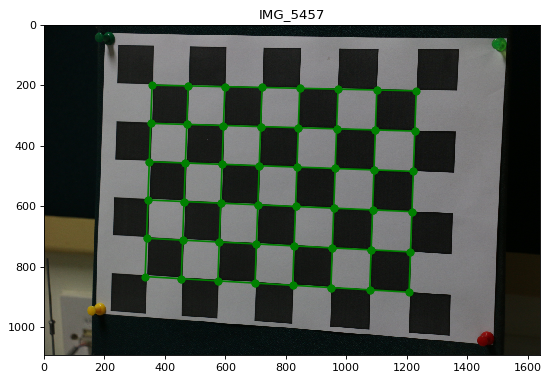

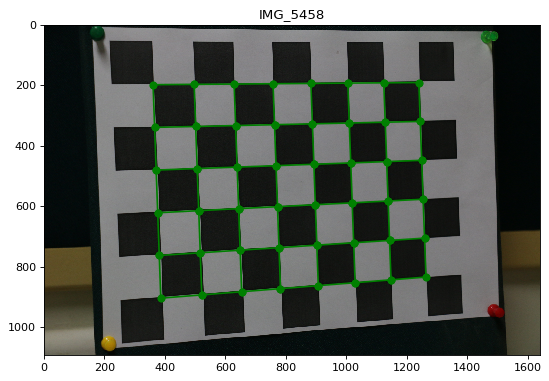

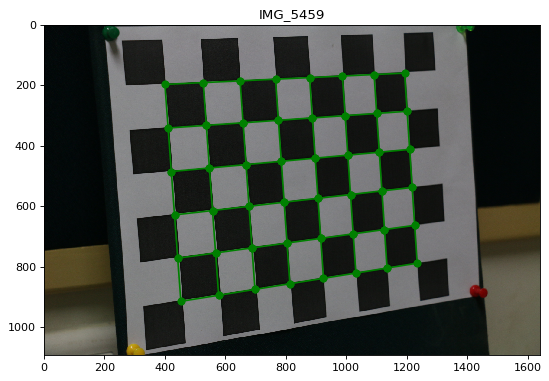

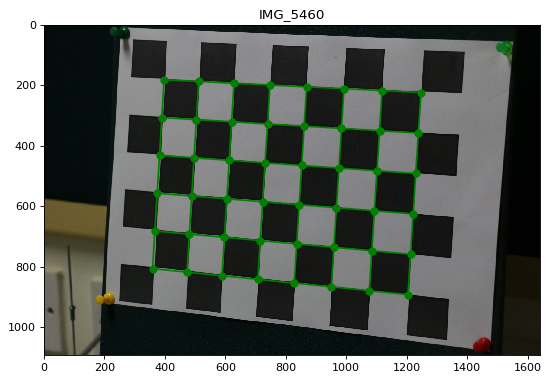

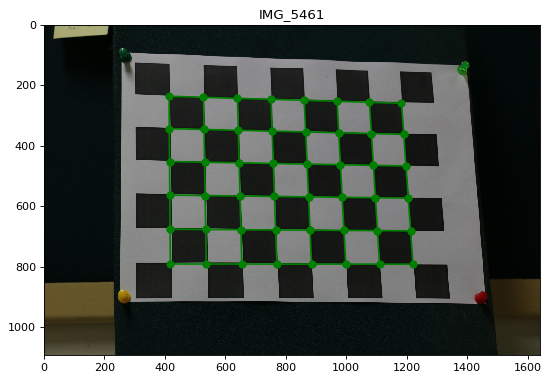

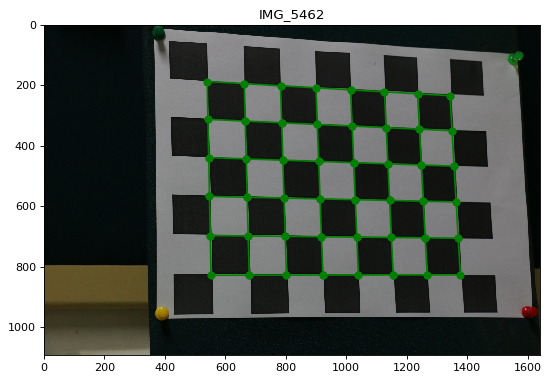

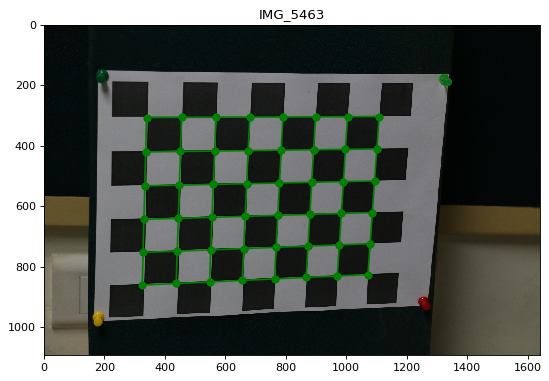

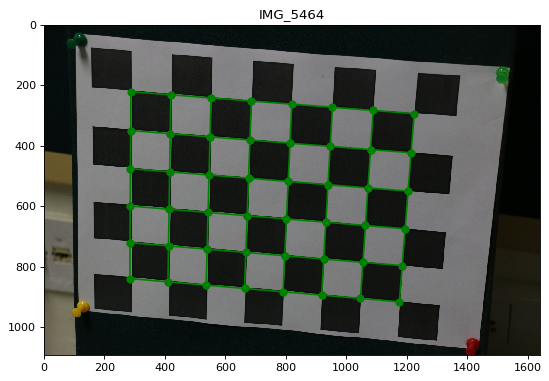

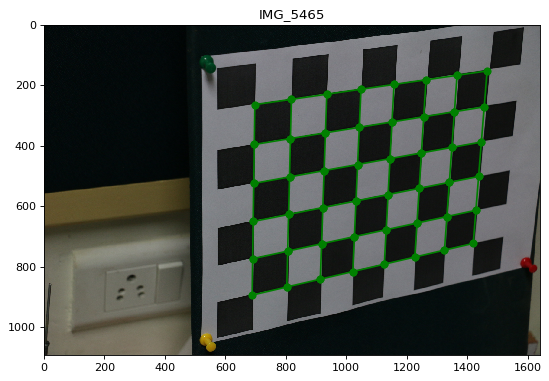

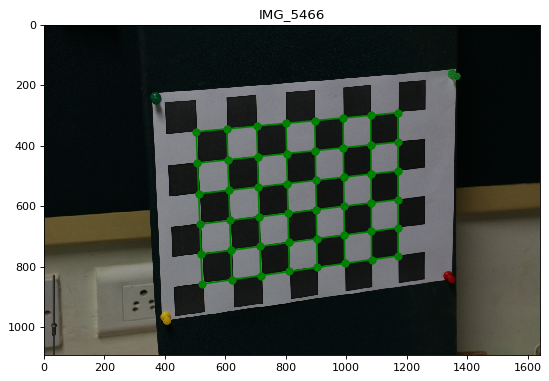

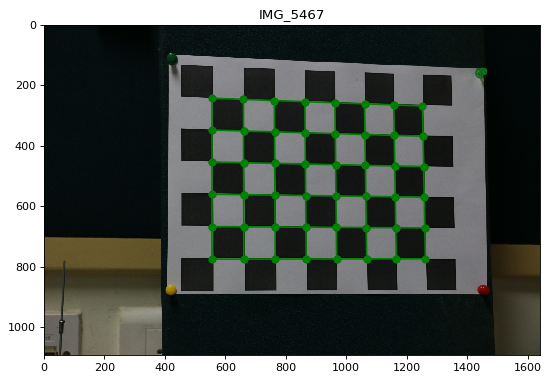

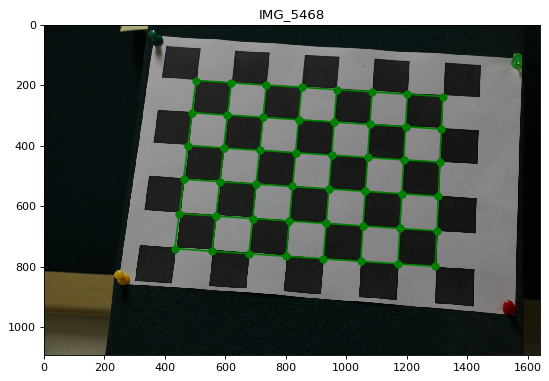

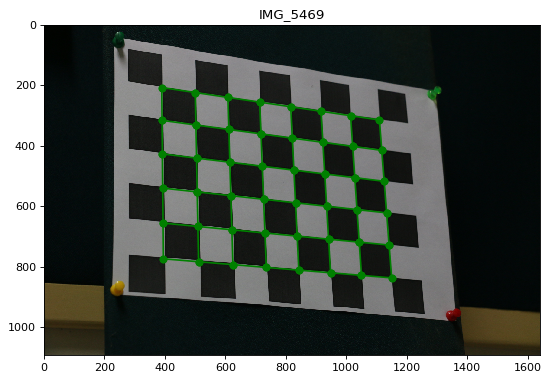

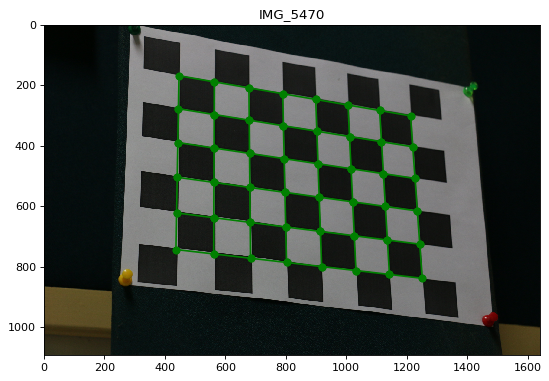

In [20]:
for k in range(15):
    rotation_mat = np.zeros(shape=(3, 3))
    R = cv2.Rodrigues(rvecs[k], rotation_mat)[0]
    world_points_1 = np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)),np.ones((48,1)))).astype(np.float32)

    temp1 = np.zeros((3,4))
    temp1[0:3,0:3] = R[0:3,0:3]
    temp1[:,3] = tvecs[k][:,0]
    P = np.matmul(mtx,temp1)
    P = P/P[2,3]

    projected_points = []
    for i in range(48):
        projection = np.matmul(P,np.transpose(world_points_1[i,:]))
        projection = projection/projection[2]
        projected_points.append(projection[0:2])
    projected_points = np.asarray(projected_points)
    np.save('IMG_'+str(5456 + k)+'_resized',projected_points)
#     projected_points,_ = cv2.projectPoints(w_pts,rvecs[k],tvecs[k],mtx,None)
#     projected_points = projected_points[:,0,:]
    ### Wireframe
    idx = [7,15,23,31,39,47]
    q = 0
    p = 0
    fig = plt.figure(figsize=(8,8),dpi=80)
    for i in range(projected_points.shape[0]):
        if (i == idx[q]):
            q = q + 1
            continue
        plt.plot([projected_points[i][0],projected_points[i+1][0]],[projected_points[i][1],projected_points[i+1][1]],'go-')
    for i in range(8):
        i1 = i
        j =  i + 8
        while(j < 48):
            plt.plot([projected_points[i1][0],projected_points[j][0]],[projected_points[i1][1],projected_points[j][1]],'go-')
            i1 = j
            j = j + 8
    im = imread('./Camera_calibration_data/IMG_'+str(5456 + k)+'.JPG')
    scale_percent = 30 # percent of original size
    width = int(im.shape[1] * scale_percent / 100)
    height = int(im.shape[0] * scale_percent / 100)
    dim = (width, height)
    im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    plt.imshow(im)
    plt.title('IMG_'+str(5456 + k))
    plt.savefig('IMG_'+str(5456 + k)+'_Wireframe.jpg')
    plt.show()
    



>The overlay is mostly accurate, but for some images it has a slight offset with the points in the chessboard corners. This is most clear in the last example.

*What is the image of the world origin, given the calibration matrix? Does this result
bear out in your observations?*

>I have resized the images to 30% size for fast computation. In the reduced size, it corresponds approximately to (141, 80) in the resized world coordinate. We can scale and find back. Practical computations match the result. The projections are stored as a .npy matrix.

## Task 3 

## Hands on

## DLT Method

<IPython.core.display.Javascript object>


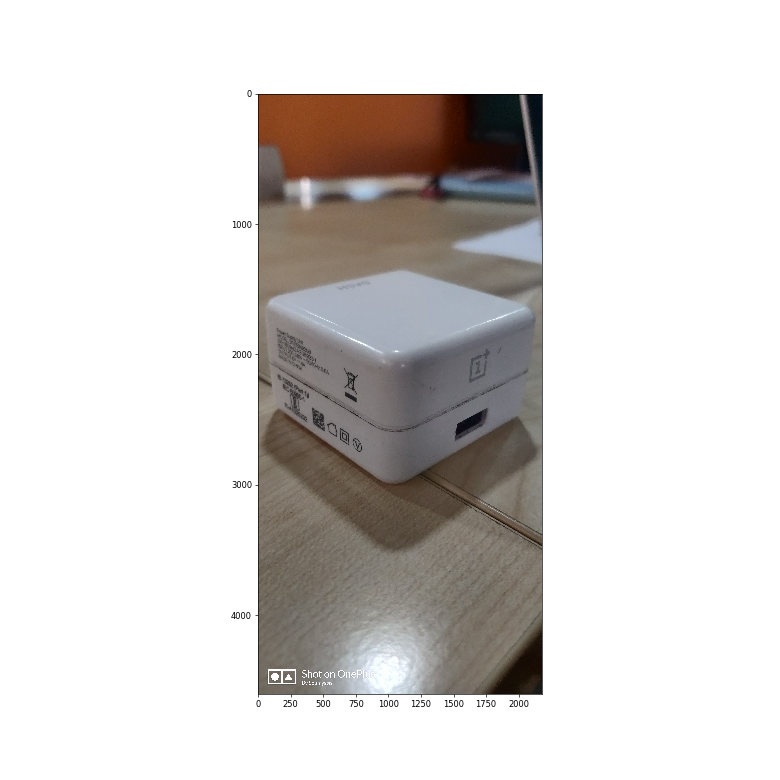

In [37]:
charger = imread('./Camera_calibration_data/self/charger_view_1.jpg')
plt.figure(figsize = [13,13], dpi = 60)
plt.imshow(charger)
# plt.axis('off')
plt.show()

In [38]:
n=10
world = np.zeros((n,3))
world[:,0] = np.array([[0, 0, 0, 0, 0, 0, 5, 5, 5, 5]])
world[:,1] = np.array([[0, 0, 0, 5, 5, 5, 0, 0, 0, 5]])
world[:,2] = np.array([[0, 1.5, 3, 0, 1.5, 3, 0, 1.5, 3, 3]])
world = world.astype('int64')
image = np.zeros((n,2))
image[:,0] = np.array([[1034, 1050, 1035, 145, 91, 68, 2009, 2078, 2109, 1112]])
image[:,1] = np.array([[3010, 2604, 2083, 2420, 2075, 1638, 2482, 2121, 1676, 1384]])
image = image.astype('int64')
print('world = \n',world)
print('image = \n',image)

world = 
 [[0 0 0]
 [0 0 1]
 [0 0 3]
 [0 5 0]
 [0 5 1]
 [0 5 3]
 [5 0 0]
 [5 0 1]
 [5 0 3]
 [5 5 3]]
image = 
 [[1034 3010]
 [1050 2604]
 [1035 2083]
 [ 145 2420]
 [  91 2075]
 [  68 1638]
 [2009 2482]
 [2078 2121]
 [2109 1676]
 [1112 1384]]


#### Using Vanilla DLT

In [39]:
P_self, R_self, K_self, C_self, e_self = calibration(world, image, normalise=True)
print('P = \n',P_self)
print('K = \n',K_self)
print('R = \n',R_self)
print('Translation = \n',C_self)
print('Error = ',e_self)

P = 
 [[ 2.99249742e+02 -1.76951256e+02 -1.82535958e+01  1.03479355e+03]
 [ 8.63086101e+00  3.36157525e+00 -3.51493221e+02  2.97401174e+03]
 [ 4.79006332e-02  5.11259190e-02 -1.99578133e-02  1.00000000e+00]]
K = 
 [[-299.37418416  176.78078048   28.3794475 ]
 [   0.           -8.4619982   350.80557015]
 [   0.            0.            3.27684862]]
R = 
 [[-9.99584326e-01  2.88299087e-02  1.10621994e-04]
 [-2.88296769e-02 -9.99540278e-01 -9.38517331e-03]
 [-1.60002551e-04 -9.38446133e-03  9.99955952e-01]]
Translation = 
 [-8.13207691 -8.74817966  8.17773167]
Error =  48.05111366573452


#### Using RANSAC Based DLT

In [74]:
P_self_best, K_self_best, R_self_best, C_self_best, e_self_best = run_ransac(world, image, n = 10, iters = 20, num_pts = 6, normalise = True, init_err = 48)
print('P = \n',P_self_best)
print('K = \n',K_self_best)
print('R = \n',R_self_best)
print('Translation = \n',C_self_best)
print('Error = ',e_self_best)

iter # 1
error =  21.000404177645713
--------------------------------------------------
iter # 2
error =  21.000404177645713
--------------------------------------------------
iter # 3
error =  5.960268135408808
--------------------------------------------------
iter # 4
error =  0.7820955013361109
--------------------------------------------------
iter # 5
error =  0.7820955013361109
--------------------------------------------------
iter # 6
error =  0.7820955013361109
--------------------------------------------------
iter # 7
error =  0.7820955013361109
--------------------------------------------------
iter # 8
error =  0.7820955013361109
--------------------------------------------------
iter # 9
error =  0.7820955013361109
--------------------------------------------------
iter # 10
error =  0.7820955013361109
--------------------------------------------------
iter # 11
error =  0.7820955013361109
--------------------------------------------------
iter # 12
error =  0.7820955013

## Zhang's Method

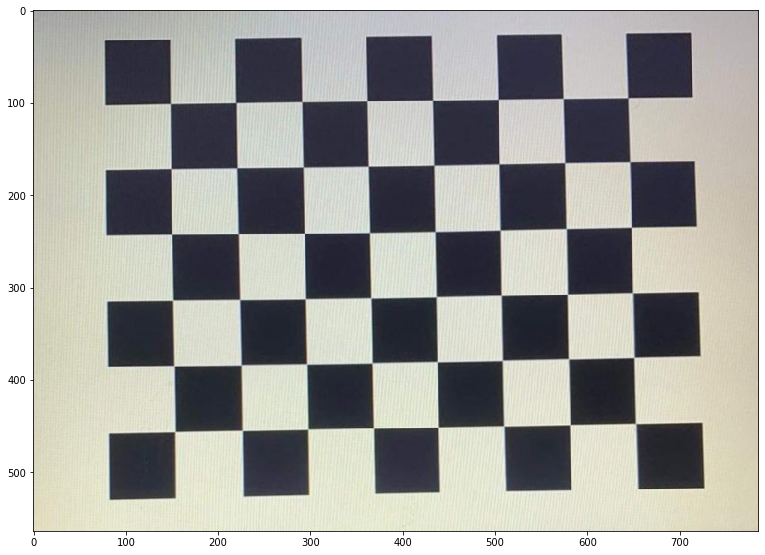

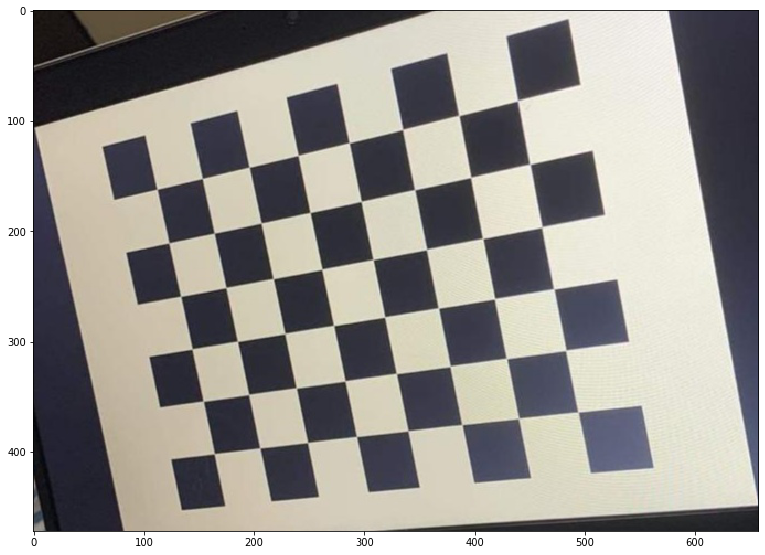

(48, 2)
[148.49004  101.443565]


In [21]:
I1 = imread('./Camera_calibration_data/self/cb/1.jpeg')
I2 = imread('./Camera_calibration_data/self/cb/2.jpeg')
# scale_percent = 30 # percent of original size
# width = int(I1.shape[1] * scale_percent / 100)
# height = int(I1.shape[0] * scale_percent / 100)
# dim = (width, height)
# I1 = cv2.resize(I1, dim, interpolation = cv2.INTER_AREA)
# width = int(I1.shape[1] * scale_percent / 100)
# height = int(I1.shape[0] * scale_percent / 100)
# dim = (width, height)
# I2 = cv2.resize(I2, dim, interpolation = cv2.INTER_AREA)
# plt.subplot(121)
plt.figure(figsize=[13,13])
plt.imshow(I1)
plt.show()
# plt.subplot(122)
plt.figure(figsize = [13,13])
plt.imshow(I2)
plt.show()
ret, corners = cv2.findChessboardCorners(I1
                                         ,(8,6)
#                                          ,flags=cv2.CALIB_CB_ADAPTIVE_THRESH+cv2.CALIB_CB_NORMALIZE_IMAGE
                                        )
corners = corners.reshape(-1,2)
print (corners.shape)
print (corners[0])
x,y=np.meshgrid(range(8),range(6))
world_points=np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)))).astype(np.float32)

In [22]:
_3d_points=[]
_2d_points=[]

for i in range(1,5):
    print('./Camera_calibration_data/self/cb/' + str(i) + '.jpeg')
    im=cv2.imread('./Camera_calibration_data/self/cb/' + str(i) + '.jpeg')
    ret, corners = cv2.findChessboardCorners(im, (8,6))
    if ret: #add points only if checkerboard was correctly detected:
        _2d_points.append(corners) #append current 2D points
        _3d_points.append(world_points) #3D points are always the same
print(np.array(world_points).shape)
print(np.array(corners).shape)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(_3d_points, _2d_points, (im.shape[1],im.shape[0]), None, None)

print('Reprojection Error:', ret)
print ('Camera Calibration Matrix:')
print(mtx)
print('Distortion Parameters:')
print(dist)
print('Rotation Vectors for the images are:')
print(rvecs)
print('Translation Vectors for the images are:')
print(tvecs)


./Camera_calibration_data/self/cb/1.jpeg
./Camera_calibration_data/self/cb/2.jpeg
./Camera_calibration_data/self/cb/3.jpeg
./Camera_calibration_data/self/cb/4.jpeg
(48, 3)
(48, 1, 2)
Reprojection Error: 1.146734412054135
Camera Calibration Matrix:
[[966.85061989   0.         335.97184352]
 [  0.         967.28951862 245.50865065]
 [  0.           0.           1.        ]]
Distortion Parameters:
[[ 2.14570142e-01 -1.97310095e+00 -5.47730622e-03  1.67855108e-04
   6.61248019e+00]]
Rotation Vectors for the images are:
[array([[-0.01772774],
       [-0.01686988],
       [-0.01613904]]), array([[ 0.09253743],
       [ 0.41317565],
       [-0.18688877]]), array([[-0.30443534],
       [ 0.03415215],
       [ 0.02982995]]), array([[-0.23432582],
       [-0.01009601],
       [-0.01120888]])]
Translation Vectors for the images are:
[array([[-2.6287336 ],
       [-2.02663092],
       [13.69928993]]), array([[-4.51293841],
       [-1.67962506],
       [19.68998341]]), array([[-2.79995835],
       

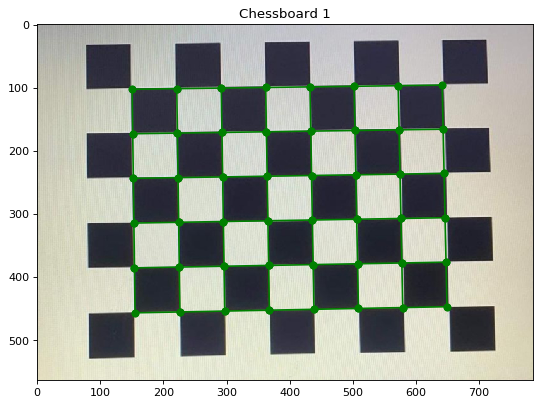

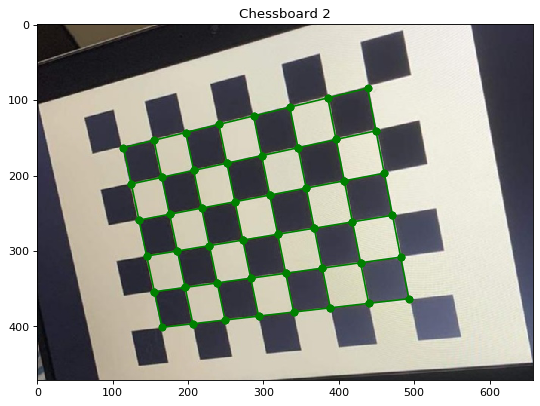

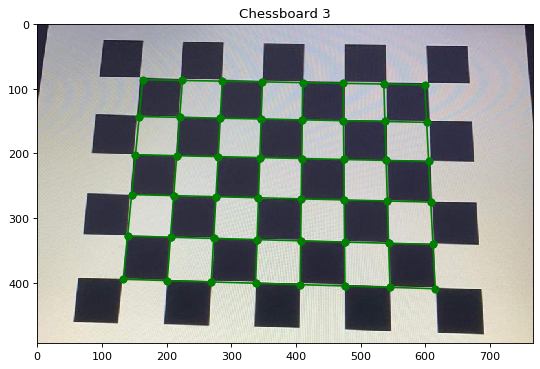

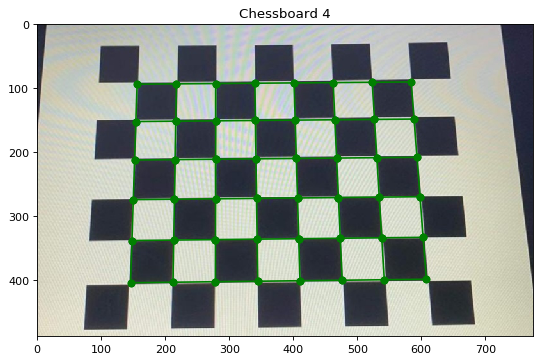

In [23]:
# %matplotlib inline
for k in range(4):
    rotation_mat = np.zeros(shape=(3, 3))
    R = cv2.Rodrigues(rvecs[k], rotation_mat)[0]
    world_points_1 = np.hstack((x.reshape(48,1),y.reshape(48,1),np.zeros((48,1)),np.ones((48,1)))).astype(np.float32)

    temp1 = np.zeros((3,4))
    temp1[0:3,0:3] = R[0:3,0:3]
    temp1[:,3] = tvecs[k][:,0]
    P = np.matmul(mtx,temp1)
    P = P/P[2,3]

    projected_points = []
    for i in range(48):
        projection = np.matmul(P,np.transpose(world_points_1[i,:]))
        projection = projection/projection[2]
        projected_points.append(projection[0:2])
    projected_points = np.asarray(projected_points)
    np.save('./Camera_calibration_data/self/cb/mat1'+str(k+1)+'_resized',projected_points)
#     projected_points,_ = cv2.projectPoints(w_pts,rvecs[k],tvecs[k],mtx,None)
#     projected_points = projected_points[:,0,:]
    ### Wireframe
    idx = [7,15,23,31,39,47]
    q = 0
    p = 0
    fig = plt.figure(figsize=(8,8),dpi=80)
    for i in range(projected_points.shape[0]):
        if (i == idx[q]):
            q = q + 1
            continue
        plt.plot([projected_points[i][0],projected_points[i+1][0]],[projected_points[i][1],projected_points[i+1][1]],'go-')
    for i in range(8):
        i1 = i
        j =  i + 8
        while(j < 48):
            plt.plot([projected_points[i1][0],projected_points[j][0]],[projected_points[i1][1],projected_points[j][1]],'go-')
            i1 = j
            j = j + 8
    im = imread('./Camera_calibration_data/self/cb/'+str(k+1)+'.jpeg')
#     scale_percent = 30 # percent of original size
#     width = int(im.shape[1] * scale_percent / 100)
#     height = int(im.shape[0] * scale_percent / 100)
#     dim = (width, height)
#     im = cv2.resize(im, dim, interpolation = cv2.INTER_AREA)
    plt.imshow(im)
    plt.savefig('Chessboard '+str(k+1)+'_wireframe.jpg')
    plt.title('Chessboard '+str(k+1))
plt.show() 


## Varying Focus for Zhang's Method

> Since Zhang's calibration method is using 2D world information, changing focus will not affect results.

## Varying Focus for DLT Method

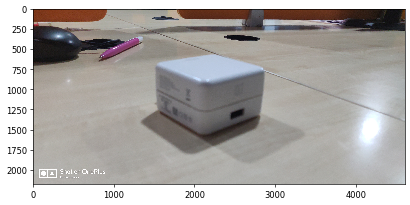

In [67]:
charger = imread('./Camera_calibration_data/self/vf/vf1.jpg')
plt.figure(figsize = [8,8], dpi = 60)
plt.imshow(charger)
# plt.axis('off')
plt.show()

In [68]:
n=10
world = np.zeros((n,3))
world[:,0] = np.array([[0, 0, 0, 0, 0, 0, 5, 5, 5, 5]])
world[:,1] = np.array([[0, 0, 0, 5, 5, 5, 0, 0, 0, 5]])
world[:,2] = np.array([[0, 1.5, 3, 0, 1.5, 3, 0, 1.5, 3, 3]])
world = world.astype('int64')
image = np.zeros((n,2))
image[:,0] = np.array([[2086, 2129, 2129, 1550, 1530, 1524, 2798, 2843, 2861, 2231]])
image[:,1] = np.array([[1574, 1275, 942, 1252, 1015, 719, 1310, 1070, 778, 579]])
image = image.astype('int64')
print('world = \n',world)
print('image = \n',image)

world = 
 [[0 0 0]
 [0 0 1]
 [0 0 3]
 [0 5 0]
 [0 5 1]
 [0 5 3]
 [5 0 0]
 [5 0 1]
 [5 0 3]
 [5 5 3]]
image = 
 [[2086 1574]
 [2129 1275]
 [2129  942]
 [1550 1252]
 [1530 1015]
 [1524  719]
 [2798 1310]
 [2843 1070]
 [2861  778]
 [2231  579]]


#### Vanilla DLT

In [76]:
P_self_focus, R_self_focus, K_self_focus, C_self_focus, e_self_focus = calibration(world, image, normalise=True)
print('P = \n',P_self_focus)
print('K = \n',K_self_focus)
print('R = \n',R_self_focus)
print('Translation = \n',C_self_focus)
print('Error = ',e_self_focus)

P = 
 [[ 2.33938211e+02 -5.73994884e+01 -8.94012322e+00  2.10470998e+03]
 [-8.79874225e+00 -1.67977980e+01 -2.11766534e+02  1.53789182e+03]
 [ 3.23639600e-02  3.76009859e-02 -7.91256355e-03  1.00000000e+00]]
K = 
 [[-234.10362169   56.72758436    0.97460064]
 [   0.           18.94333324  211.95229331]
 [   0.            0.           -0.51623394]]
R = 
 [[-9.99293432e-01 -3.75850426e-02 -4.79855994e-05]
 [ 3.75848190e-02 -9.99290553e-01  2.40241169e-03]
 [-1.38246302e-04  2.39891069e-03  9.99997113e-01]]
Translation = 
 [-12.1556384  -14.25990093   8.89838937]
Error =  35.50384773696447


#### RANSAC Based DLT

In [80]:
P_focus_best, K_focus_best, R_focus_best, C_focus_best, e_focus_best = run_ransac(world, image, n = 10, iters = 20, num_pts = 6, normalise = True, init_err = 48)
print('P = \n',P_focus_best)
print('K = \n',K_focus_best)
print('R = \n',R_focus_best)
print('Translation = \n',C_focus_best)
print('Error = ',e_focus_best)

iter # 1
error =  0.2876181279072282
--------------------------------------------------
iter # 2
error =  0.2876181279072282
--------------------------------------------------
iter # 3
error =  0.2876181279072282
--------------------------------------------------
iter # 4
error =  0.2876181279072282
--------------------------------------------------
iter # 5
error =  0.08905073270932945
--------------------------------------------------
iter # 6
error =  0.08905073270932945
--------------------------------------------------
iter # 7
error =  0.08905073270932945
--------------------------------------------------
iter # 8
error =  0.08905073270932945
--------------------------------------------------
iter # 9
error =  0.08905073270932945
--------------------------------------------------
iter # 10
error =  0.08905073270932945
--------------------------------------------------
iter # 11
error =  0.08905073270932945
--------------------------------------------------
iter # 12
error =  0.08

>We can observe that the focal length is inversely proportional to the focussed distance. Since phone cameras are do not acknowledge much changes in focal distance compared to actual ground distance, the parameters $fx$ and $fy$ are not much affected. Rest all parameters should ideally be same, but owing to lighting and human motion variation, even they will change slightly.